# **Pengenalan Data yang Digunakan**

Data yang digunakan untuk membangun model sistem rekomendasi pada website Jogjadventure adalah dataset pariwisata Yogyakarta yang diperoleh dari Kaggle.
Link sumber data: https://www.kaggle.com/datasets/saufan/dataset-pariwisata-yogyakarta/data

# **Import Libraries**

In [ ]:
# Untuk load data dari gdrive
from google.colab import drive

# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras import layers, models

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

# Install geopy
!pip install geopy

# Import Nominatim
from geopy.geocoders import Nominatim

# **Load Dataset**

In [ ]:
url = 'https://drive.google.com/file/d/158UBn9FP8mD1gJ9ZdbgYuoqTH4zpdAP9/view?usp=drive_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df_tour = pd.read_csv(path)

In [ ]:
df_tour.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Latitude,Longitude
0,85.0,Taman Pintar Yogyakarta,Taman Pintar Yogyakarta (bahasa Jawa: Hanacara...,Taman Hiburan,Yogyakarta,6000,4.5,120.0,"{'lat': -7.800671500000001, 'lng': 110.3676551}",-7.800671,110.367655
1,86.0,Keraton Yogyakarta,Keraton Ngayogyakarta Hadiningrat atau Keraton...,Budaya,Yogyakarta,15000,4.6,NaN,"{'lat': -7.8052845, 'lng': 110.3642031}",-7.805284,110.364203
2,87.0,Sindu Kusuma Edupark (SKE),Sindu Kusuma Edupark (SKE) merupakan sebuah de...,Taman Hiburan,Yogyakarta,20000,4.2,120.0,"{'lat': -7.767297300000001, 'lng': 110.3542486}",-7.767297,110.354249
3,88.0,Museum Benteng Vredeburg Yogyakarta,Museum Benteng Vredeburg (bahasa Jawa: ???????...,Budaya,Yogyakarta,3000,4.6,120.0,"{'lat': -7.800201599999999, 'lng': 110.3663044}",-7.800202,110.366304
4,89.0,De Mata Museum Jogja,Museum De Mata merupakan salah satu museum yan...,Budaya,Yogyakarta,50000,4.4,NaN,"{'lat': -7.816315599999999, 'lng': 110.3871442}",-7.816316,110.387144


In [ ]:
df_tour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      126 non-null    float64
 1   Place_Name    126 non-null    object 
 2   Description   126 non-null    object 
 3   Category      126 non-null    object 
 4   City          126 non-null    object 
 5   Price         126 non-null    int64  
 6   Rating        126 non-null    float64
 7   Time_Minutes  60 non-null     float64
 8   Coordinate    126 non-null    object 
 9   Latitude      126 non-null    float64
 10  Longitude     126 non-null    float64
dtypes: float64(5), int64(1), object(5)
memory usage: 11.0+ KB


Terdapat beberapa dataset pada sumber data, namun untuk membangun model sistem rekomendasi pada website Jogjadventure, hanya memerlukan dataset `tour` . Berikut keterangan fitur dataset `tour`:

*   Place_Id: ID tempat wisata (primary key)
*   Place_Name: Nama tempat wisata
*   Description: Deskripsi tempat wisata
*   Category: Kategori tempat wisata
*   City: Kota dari tempat wisata
*   Price: Harga tiket wisata
*   Rating: Penilaian dari pengunjung untuk tempat wisata
*   Time_Minutes: Lama berkunjung (menit)
*   Coordinate: Koordinat wisata, berisi latitude dan longitude
*   Latitude: Latitude tempat wisata
*   Longitude: Longitude tempat wisata









# **Data Preprocessing**

## Menghapus Fitur yang tidak digunakan

In [ ]:
df_tour.drop(columns=['City','Time_Minutes'], inplace=True)

Fitur `City` tidak digunakan karena tidak memberikan informasi secara spesifik terkait kota dari tempat wisata dan semua berisikan Yogyakarta.
Fitur `Time_Minutes` yang berisi lama berkunjung tidak digunakan untuk membangun model.

## Menambahkan fitur Address

Fitur `Address` berisi alamat lengkap dari tempat wisata. Alamat dapat diperoleh berdasarkan fitur `Latitude` dan `Longitude`.

In [ ]:
# Fungsi reverse geocode
def reverse_geocode(lat, lon):
    geolocator = Nominatim(user_agent="myGeocoder")
    location = geolocator.reverse((lat, lon), language='en')
    return location.address if location else "Unknown location"
df_tour['Address'] = df_tour.apply(lambda row: reverse_geocode(row['Latitude'], row['Longitude']), axis=1)
display(df_tour)

,Place_Id,Place_Name,Description,Category,Price,Rating,Coordinate,Latitude,Longitude,Address
0,85.0,Taman Pintar Yogyakarta,Taman Pintar Yogyakarta (bahasa Jawa: Hanacara...,Taman Hiburan,6000,4.5,"{'lat': -7.800671500000001, 'lng': 110.3676551}",-7.800671,110.367655,"Jalan Sriwedani, Kampung Ketandan, Prawirodirj..."
1,86.0,Keraton Yogyakarta,Keraton Ngayogyakarta Hadiningrat atau Keraton...,Budaya,15000,4.6,"{'lat': -7.8052845, 'lng': 110.3642031}",-7.805284,110.364203,"Royal Palace of Yogyakarta, Jalan Pesindenan, ..."
2,87.0,Sindu Kusuma Edupark (SKE),Sindu Kusuma Edupark (SKE) merupakan sebuah de...,Taman Hiburan,20000,4.2,"{'lat': -7.767297300000001, 'lng': 110.3542486}",-7.767297,110.354249,"Sindu Kusuma Edupark, Jalan Jambon V, Kricak, ..."
3,88.0,Museum Benteng Vredeburg Yogyakarta,Museum Benteng Vredeburg (bahasa Jawa: ???????...,Budaya,3000,4.6,"{'lat': -7.800201599999999, 'lng': 110.3663044}",-7.800202,110.366304,"Benteng Vredeburg, Jalan Margo Mulyo, Kampung ..."
4,89.0,De Mata Museum Jogja,Museum De Mata merupakan salah satu museum yan...,Budaya,50000,4.4,"{'lat': -7.816315599999999, 'lng': 110.3871442}",-7.816316,110.387144,"XT Square, Jalan Veteran, Gambiran, Pandeyan, ..."
...,...,...,...,...,...,...,...,...,...,...
121,206.0,Wisata Kaliurang,"Jogja selalu menarik untuk dikulik, terlebih t...",Cagar Alam,8000,4.4,"{'lat': -7.6120675, 'lng': 110.4205209}",-7.612068,110.420521,"Jalan Boyong, Ngipiksari, Kaliurang, Hargobina..."
122,207.0,Heha Sky View,HeHa Sky View adalah salah satu tempat wisata ...,Taman Hiburan,15000,4.4,"{'lat': -7.8496144, 'lng': 110.478324}",-7.849614,110.478324,"Resto HeHa sky view, Jalan Sindangsari, Patuk,..."
123,208.0,Taman Sungai Mudal,"Taman Sungai Mudal, sebuah objek wisata alam t...",Cagar Alam,10000,4.6,"{'lat': -7.762813599999998, 'lng': 110.1161626}",-7.762814,110.116163,"Taman Sungai Mudal, Jalan Clapar, Bukit WIsata..."
124,209.0,Pantai Sanglen,Pantai Sanglen. Lokasinya berada di Desa Kemad...,Bahari,10000,4.5,"{'lat': -8.1367456, 'lng': 110.5716362}",-8.136746,110.571636,"Pantai Sangleng, Jalan Pantai Sepanjang, Kemad..."


## Membuat fitur City baru

Fitur `City` baru berisi kota tempat wisata yang diambil dari kolom `Address`

In [ ]:
def extract_city(address):
    cities = ['Kulonprogo', 'Gunung Kidul', 'Bantul', 'Sleman']
    for city in cities:
        if city in address:
            return city
    return 'Yogyakarta'  # Default jika tidak ada kota yang cocok

# Terapkan fungsi pada kolom 'Address'
df_tour['City'] = df_tour['Address'].apply(extract_city)

# Hasil
display(df_tour)

,Place_Id,Place_Name,Description,Category,Price,Rating,Coordinate,Latitude,Longitude,Address,City
0,85.0,Taman Pintar Yogyakarta,Taman Pintar Yogyakarta (bahasa Jawa: Hanacara...,Taman Hiburan,6000,4.5,"{'lat': -7.800671500000001, 'lng': 110.3676551}",-7.800671,110.367655,"Jalan Sriwedani, Kampung Ketandan, Prawirodirj...",Yogyakarta
1,86.0,Keraton Yogyakarta,Keraton Ngayogyakarta Hadiningrat atau Keraton...,Budaya,15000,4.6,"{'lat': -7.8052845, 'lng': 110.3642031}",-7.805284,110.364203,"Royal Palace of Yogyakarta, Jalan Pesindenan, ...",Yogyakarta
2,87.0,Sindu Kusuma Edupark (SKE),Sindu Kusuma Edupark (SKE) merupakan sebuah de...,Taman Hiburan,20000,4.2,"{'lat': -7.767297300000001, 'lng': 110.3542486}",-7.767297,110.354249,"Sindu Kusuma Edupark, Jalan Jambon V, Kricak, ...",Sleman
3,88.0,Museum Benteng Vredeburg Yogyakarta,Museum Benteng Vredeburg (bahasa Jawa: ???????...,Budaya,3000,4.6,"{'lat': -7.800201599999999, 'lng': 110.3663044}",-7.800202,110.366304,"Benteng Vredeburg, Jalan Margo Mulyo, Kampung ...",Yogyakarta
4,89.0,De Mata Museum Jogja,Museum De Mata merupakan salah satu museum yan...,Budaya,50000,4.4,"{'lat': -7.816315599999999, 'lng': 110.3871442}",-7.816316,110.387144,"XT Square, Jalan Veteran, Gambiran, Pandeyan, ...",Yogyakarta
...,...,...,...,...,...,...,...,...,...,...,...
121,206.0,Wisata Kaliurang,"Jogja selalu menarik untuk dikulik, terlebih t...",Cagar Alam,8000,4.4,"{'lat': -7.6120675, 'lng': 110.4205209}",-7.612068,110.420521,"Jalan Boyong, Ngipiksari, Kaliurang, Hargobina...",Sleman
122,207.0,Heha Sky View,HeHa Sky View adalah salah satu tempat wisata ...,Taman Hiburan,15000,4.4,"{'lat': -7.8496144, 'lng': 110.478324}",-7.849614,110.478324,"Resto HeHa sky view, Jalan Sindangsari, Patuk,...",Gunung Kidul
123,208.0,Taman Sungai Mudal,"Taman Sungai Mudal, sebuah objek wisata alam t...",Cagar Alam,10000,4.6,"{'lat': -7.762813599999998, 'lng': 110.1161626}",-7.762814,110.116163,"Taman Sungai Mudal, Jalan Clapar, Bukit WIsata...",Kulonprogo
124,209.0,Pantai Sanglen,Pantai Sanglen. Lokasinya berada di Desa Kemad...,Bahari,10000,4.5,"{'lat': -8.1367456, 'lng': 110.5716362}",-8.136746,110.571636,"Pantai Sangleng, Jalan Pantai Sepanjang, Kemad...",Gunung Kidul


## Identifikasi missing value dan duplikasi data

In [ ]:
df_tour['Place_Id'].isnull().sum()

np.int64(0)

In [ ]:
df_tour.duplicated('Place_Id').sum()

np.int64(0)

Terlihat bahwa data tidak memiliki missing value dan duplikasi data.

## Identifikasi outlier

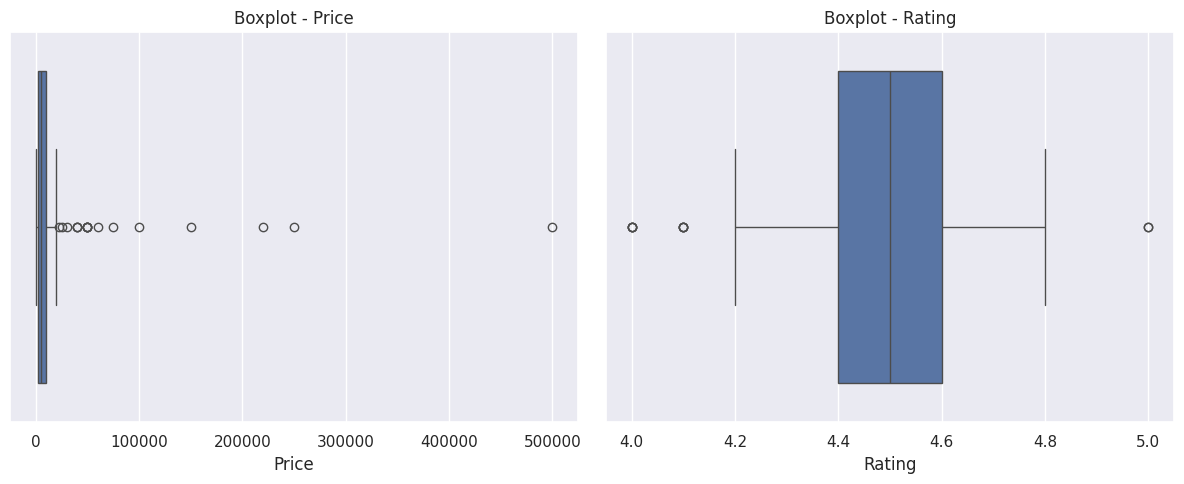

In [ ]:
# Ukuran figure
plt.figure(figsize=(12, 5))

# Boxplot untuk kolom Price
plt.subplot(1, 2, 1)
sns.boxplot(x=df_tour['Price'])
plt.title('Boxplot - Price')

# Boxplot untuk kolom Rating
plt.subplot(1, 2, 2)
sns.boxplot(x=df_tour['Rating'])
plt.title('Boxplot - Rating')

plt.tight_layout()
plt.show()

Berdasarkan boxplot, terlihat bahwa data `Price` tidak memiliki outlier karena setelah dilakukan research masih sesuai dengan harga wisata di Yogyakarta. Selain itu, tidak terdapat outlier pada Rating karena masih dalam rentang rating, yaitu bintang 1 sampai 5.

In [ ]:
df_tour.Category.unique()

array(['Taman Hiburan', 'Budaya', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan'], dtype=object)

In [ ]:
df_tour.City.unique()

array(['Yogyakarta', 'Sleman', 'Bantul', 'Gunung Kidul', 'Kulonprogo'],
      dtype=object)

Tidak terdapat unique value pada fitur `Category` dan `City`

## Menampilkan konten

In [ ]:
# Mengambil fitur-fitur yang akan digunakan sebagai konten: Place_Name, Category, City, dan Price
content_data = df_tour[['Place_Name', 'Category', 'City', 'Price']].copy()

print("Data sebelum pengelompokkan harga):")
print(content_data.head())
print("\nBentuk data:", content_data.shape)

Data sebelum pengelompokkan harga):
                            Place_Name       Category        City  Price
0              Taman Pintar Yogyakarta  Taman Hiburan  Yogyakarta   6000
1                   Keraton Yogyakarta         Budaya  Yogyakarta  15000
2           Sindu Kusuma Edupark (SKE)  Taman Hiburan      Sleman  20000
3  Museum Benteng Vredeburg Yogyakarta         Budaya  Yogyakarta   3000
4                 De Mata Museum Jogja         Budaya  Yogyakarta  50000

Bentuk data: (126, 4)


## Mengelompokkan Price

Pengelompokan harga dilakukan karena `Price` akan menjadi salah satu referensi pengunjung pada model sistem rekomendasi.

In [ ]:
def group_price(price):
    if price == 0:
        return '0'
    elif 1 <= price <= 50000:
        return '50000'
    elif 51000 <= price <= 100000:
        return '100000'
    elif 101000 <= price <= 150000:
        return '150000'
    elif 151000 <= price <= 200000:
        return '200000'
    else: # Untuk harga di atas 200 ribu
        return '>200000'

# Terapkan fungsi pengelompokkan pada kolom Price di DataFrame 'data'
df_tour['Price_Grouped'] = df_tour['Price'].apply(group_price)

# Tampilkan beberapa nilai dari kolom baru
print("\nContoh Kolom Harga yang Dikelompokkan di DataFrame 'data':")
print(df_tour[['Price', 'Price_Grouped']].head(40))


Contoh Kolom Harga yang Dikelompokkan di DataFrame 'data':
     Price Price_Grouped
0     6000         50000
1    15000         50000
2    20000         50000
3     3000         50000
4    50000         50000
5     5000         50000
6        0             0
7        0             0
8    60000        100000
9     7000         50000
10       0             0
11       0             0
12   15000         50000
13   15000         50000
14       0             0
15       0             0
16       0             0
17   40000         50000
18       0             0
19   20000         50000
20       0             0
21       0             0
22    5000         50000
23       0             0
24    3000         50000
25    3000         50000
26    3000         50000
27   25000         50000
28       0             0
29   30000         50000
30   15000         50000
31    2500         50000
32   22000         50000
33    5000         50000
34    5000         50000
35  250000       >200000
36   50000     

In [ ]:
Price_count = df_tour['Price_Grouped'].value_counts()
print(Price_count)

Price_Grouped
50000      94
0          25
100000      3
>200000     3
150000      1
Name: count, dtype: int64


In [ ]:
display(df_tour)

,Place_Id,Place_Name,Description,Category,Price,Rating,Coordinate,Latitude,Longitude,Address,City,Price_Grouped
0,85.0,Taman Pintar Yogyakarta,Taman Pintar Yogyakarta (bahasa Jawa: Hanacara...,Taman Hiburan,6000,4.5,"{'lat': -7.800671500000001, 'lng': 110.3676551}",-7.800671,110.367655,"Jalan Sriwedani, Kampung Ketandan, Prawirodirj...",Yogyakarta,50000
1,86.0,Keraton Yogyakarta,Keraton Ngayogyakarta Hadiningrat atau Keraton...,Budaya,15000,4.6,"{'lat': -7.8052845, 'lng': 110.3642031}",-7.805284,110.364203,"Royal Palace of Yogyakarta, Jalan Pesindenan, ...",Yogyakarta,50000
2,87.0,Sindu Kusuma Edupark (SKE),Sindu Kusuma Edupark (SKE) merupakan sebuah de...,Taman Hiburan,20000,4.2,"{'lat': -7.767297300000001, 'lng': 110.3542486}",-7.767297,110.354249,"Sindu Kusuma Edupark, Jalan Jambon V, Kricak, ...",Sleman,50000
3,88.0,Museum Benteng Vredeburg Yogyakarta,Museum Benteng Vredeburg (bahasa Jawa: ???????...,Budaya,3000,4.6,"{'lat': -7.800201599999999, 'lng': 110.3663044}",-7.800202,110.366304,"Benteng Vredeburg, Jalan Margo Mulyo, Kampung ...",Yogyakarta,50000
4,89.0,De Mata Museum Jogja,Museum De Mata merupakan salah satu museum yan...,Budaya,50000,4.4,"{'lat': -7.816315599999999, 'lng': 110.3871442}",-7.816316,110.387144,"XT Square, Jalan Veteran, Gambiran, Pandeyan, ...",Yogyakarta,50000
...,...,...,...,...,...,...,...,...,...,...,...,...
121,206.0,Wisata Kaliurang,"Jogja selalu menarik untuk dikulik, terlebih t...",Cagar Alam,8000,4.4,"{'lat': -7.6120675, 'lng': 110.4205209}",-7.612068,110.420521,"Jalan Boyong, Ngipiksari, Kaliurang, Hargobina...",Sleman,50000
122,207.0,Heha Sky View,HeHa Sky View adalah salah satu tempat wisata ...,Taman Hiburan,15000,4.4,"{'lat': -7.8496144, 'lng': 110.478324}",-7.849614,110.478324,"Resto HeHa sky view, Jalan Sindangsari, Patuk,...",Gunung Kidul,50000
123,208.0,Taman Sungai Mudal,"Taman Sungai Mudal, sebuah objek wisata alam t...",Cagar Alam,10000,4.6,"{'lat': -7.762813599999998, 'lng': 110.1161626}",-7.762814,110.116163,"Taman Sungai Mudal, Jalan Clapar, Bukit WIsata...",Kulonprogo,50000
124,209.0,Pantai Sanglen,Pantai Sanglen. Lokasinya berada di Desa Kemad...,Bahari,10000,4.5,"{'lat': -8.1367456, 'lng': 110.5716362}",-8.136746,110.571636,"Pantai Sangleng, Jalan Pantai Sepanjang, Kemad...",Gunung Kidul,50000


## Penggabungan Fitur

In [ ]:
df_tour['Content_Text'] = df_tour['Category'].astype(str) + ' ' + \
                       df_tour['City'].astype(str) + ' ' + \
                       df_tour['Price_Grouped'].astype(str)

In [ ]:
display(df_tour)

,Place_Id,Place_Name,Description,Category,Price,Rating,Coordinate,Latitude,Longitude,Address,City,Price_Grouped,Content_Text
0,85.0,Taman Pintar Yogyakarta,Taman Pintar Yogyakarta (bahasa Jawa: Hanacara...,Taman Hiburan,6000,4.5,"{'lat': -7.800671500000001, 'lng': 110.3676551}",-7.800671,110.367655,"Jalan Sriwedani, Kampung Ketandan, Prawirodirj...",Yogyakarta,50000,Taman Hiburan Yogyakarta 50000
1,86.0,Keraton Yogyakarta,Keraton Ngayogyakarta Hadiningrat atau Keraton...,Budaya,15000,4.6,"{'lat': -7.8052845, 'lng': 110.3642031}",-7.805284,110.364203,"Royal Palace of Yogyakarta, Jalan Pesindenan, ...",Yogyakarta,50000,Budaya Yogyakarta 50000
2,87.0,Sindu Kusuma Edupark (SKE),Sindu Kusuma Edupark (SKE) merupakan sebuah de...,Taman Hiburan,20000,4.2,"{'lat': -7.767297300000001, 'lng': 110.3542486}",-7.767297,110.354249,"Sindu Kusuma Edupark, Jalan Jambon V, Kricak, ...",Sleman,50000,Taman Hiburan Sleman 50000
3,88.0,Museum Benteng Vredeburg Yogyakarta,Museum Benteng Vredeburg (bahasa Jawa: ???????...,Budaya,3000,4.6,"{'lat': -7.800201599999999, 'lng': 110.3663044}",-7.800202,110.366304,"Benteng Vredeburg, Jalan Margo Mulyo, Kampung ...",Yogyakarta,50000,Budaya Yogyakarta 50000
4,89.0,De Mata Museum Jogja,Museum De Mata merupakan salah satu museum yan...,Budaya,50000,4.4,"{'lat': -7.816315599999999, 'lng': 110.3871442}",-7.816316,110.387144,"XT Square, Jalan Veteran, Gambiran, Pandeyan, ...",Yogyakarta,50000,Budaya Yogyakarta 50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,206.0,Wisata Kaliurang,"Jogja selalu menarik untuk dikulik, terlebih t...",Cagar Alam,8000,4.4,"{'lat': -7.6120675, 'lng': 110.4205209}",-7.612068,110.420521,"Jalan Boyong, Ngipiksari, Kaliurang, Hargobina...",Sleman,50000,Cagar Alam Sleman 50000
122,207.0,Heha Sky View,HeHa Sky View adalah salah satu tempat wisata ...,Taman Hiburan,15000,4.4,"{'lat': -7.8496144, 'lng': 110.478324}",-7.849614,110.478324,"Resto HeHa sky view, Jalan Sindangsari, Patuk,...",Gunung Kidul,50000,Taman Hiburan Gunung Kidul 50000
123,208.0,Taman Sungai Mudal,"Taman Sungai Mudal, sebuah objek wisata alam t...",Cagar Alam,10000,4.6,"{'lat': -7.762813599999998, 'lng': 110.1161626}",-7.762814,110.116163,"Taman Sungai Mudal, Jalan Clapar, Bukit WIsata...",Kulonprogo,50000,Cagar Alam Kulonprogo 50000
124,209.0,Pantai Sanglen,Pantai Sanglen. Lokasinya berada di Desa Kemad...,Bahari,10000,4.5,"{'lat': -8.1367456, 'lng': 110.5716362}",-8.136746,110.571636,"Pantai Sangleng, Jalan Pantai Sepanjang, Kemad...",Gunung Kidul,50000,Bahari Gunung Kidul 50000


# **Membangun Model dengan TensorFlow**

In [ ]:
# 1. Encode kategori ke angka
df_tour['Category_Code'] = df_tour['Category'].astype('category').cat.codes

# 2. Memilih fitur dan normalisasi
features = df_tour[['Price', 'Rating', 'Category_Code']].fillna(0).values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 3. Split data training dan testing
X_train, X_test = train_test_split(features_scaled, test_size=0.2, random_state=42)

# 4. Membangun autoencoder
input_dim = features_scaled.shape[1]
encoding_dim = 2

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='linear')(encoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
encoder = models.Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')

# 5. Training dengan validation
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=16,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1
)

# 6. Evaluasi di data test
loss_test = autoencoder.evaluate(X_test, X_test)
print("Test Reconstruction Loss:", loss_test)

# 7. Mengambil embedding seluruh data (train + test)
embeddings = encoder.predict(features_scaled)

embedding_df = pd.DataFrame(embeddings, index=df_tour['Place_Name'], columns=['Embed1', 'Embed2'])

# 8. Menghitung cosine similarity dari embedding
cosine_sim_emb = cosine_similarity(embedding_df)
cosine_sim_emb_df = pd.DataFrame(cosine_sim_emb, index=embedding_df.index, columns=embedding_df.index)

# 9. Fungsi rekomendasi
def place_recommendations(Place_Name, similarity_data, items, k=10):
    if Place_Name not in similarity_data.index:
        print(f"Tempat '{Place_Name}' tidak ditemukan dalam data kemiripan.")
        return pd.DataFrame()

    search_data = items[items['Place_Name'] == Place_Name].copy()
    search_data['_order_key'] = 0
    search_data['Cosine_Similarity_Score'] = 1.0

    idx = similarity_data.index.get_loc(Place_Name)
    sim_scores = similarity_data.iloc[idx].sort_values(ascending=False)
    top_sim_scores = sim_scores.iloc[1:k+1]

    recommendations = pd.DataFrame({
        'Place_Name': top_sim_scores.index,
        'Cosine_Similarity_Score': top_sim_scores.values
    })

    recommendations = recommendations.merge(
        items[['Place_Name', 'Category', 'City', 'Price', 'Rating']],
        on='Place_Name',
        how='left'
    )

    recommendations['_order_key'] = 1

    combined = pd.concat([
        search_data[['Place_Name', 'Category', 'City', 'Price', 'Rating', 'Cosine_Similarity_Score', '_order_key']],
        recommendations[['Place_Name', 'Category', 'City', 'Price', 'Rating', 'Cosine_Similarity_Score', '_order_key']]
    ], ignore_index=True)

    combined = combined.sort_values(by=['_order_key', 'Cosine_Similarity_Score'], ascending=[True, False])
    combined = combined.drop(columns=['_order_key'])
    combined = combined.reset_index(drop=True)

    return combined

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2.1969 - val_loss: 1.2557
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6306 - val_loss: 1.2420
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6137 - val_loss: 1.2276
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.1378 - val_loss: 1.2132
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3692 - val_loss: 1.2013
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4235 - val_loss: 1.1894
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1079 - val_loss: 1.1782
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0098 - val_loss: 1.1656
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9160 - val_loss: 1.1531
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1870 - val_loss: 1.1429
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3754 - val_loss: 1.1300
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5226 - val_loss: 1.1194
E

In [ ]:
# 10. Inference
place_to_recommend = 'Candi Sewu'  # Ganti sesuai data

recommended_places = place_recommendations(
    Place_Name=place_to_recommend,
    similarity_data=cosine_sim_emb_df,
    items=df_tour[['Place_Name', 'Category', 'City', 'Price', 'Rating']],
    k=10
)

print(f"\nRekomendasi berdasarkan '{place_to_recommend}':")
display(recommended_places)


Rekomendasi berdasarkan 'Candi Sewu':


,Place_Name,Category,City,Price,Rating,Cosine_Similarity_Score
0,Candi Sewu,Budaya,Yogyakarta,50000,4.6,1.000000
1,Goa Pindul,Cagar Alam,Gunung Kidul,40000,4.5,0.999969
2,Desa Wisata Tembi,Taman Hiburan,Bantul,50000,4.5,0.999107
3,Candi Borobudur,Budaya,Yogyakarta,50000,4.7,0.987984
4,Candi Prambanan,Budaya,Sleman,50000,4.7,0.987984
5,Bukit Bintang Yogyakarta,Taman Hiburan,Gunung Kidul,25000,4.5,0.976467
6,Jogja Exotarium,Taman Hiburan,Sleman,20000,4.4,0.967471
7,Museum Ullen Sentalu,Budaya,Sleman,100000,4.7,0.950107
8,Heha Sky View,Taman Hiburan,Gunung Kidul,15000,4.4,0.931631
9,Desa Wisata Sungai Code Jogja Kota,Taman Hiburan,Yogyakarta,0,5.0,0.928509
